# Approximate inference on BNNs with MNIST and TyXe

In [1]:
import os
os.chdir("..")

from functools import partial

from src import model
from src import evaluate
from utils import data_loaders

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import torchmetrics as tm

import pyro
import pyro.distributions as dist

import tyxe
pyro.set_rng_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print("Using", device)

Using cuda


### Download MNIST data

In [2]:
# Data transformations
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# Download MNIST data
train_data = datasets.MNIST(root="data/classification", train=True, transform=train_transform, download=True)
test_data = datasets.MNIST(root="data/classification", train=False, transform=test_transform)

NUM_CLASSES = 10

### Take subset of Dataset (pytorch dataset object)

This is done to increase performance, since these methods are computationally expensive.

In [3]:
# train_size = len(train_data)      # default value
# test_size = len(test_data)        # default value
train_size = 10000
test_size = 10000
train_batch_size = 128 
test_batch_size = 128

train_data = data_loaders.create_subset(train_data, train_size)
test_data = data_loaders.create_subset(test_data, test_size)

train_loader = data_loaders.create_loader(train_data, train_batch_size, device=device)
test_loader = data_loaders.create_loader(test_data, test_batch_size, device=device)

# Optionally separate X_train, y_train, X_test, y_test data
X_train, y_train = data_loaders.separate_torch_dataset(train_data, device=device)
X_test, y_test = data_loaders.separate_torch_dataset(test_data, device=device)

### Baseline CNN model

In [4]:
"""CNN architecture: 
    
        1st Convolutional layer:
            input channels : 1 (gray)
            output channels : 16
            kernel size : 5
            padding: 2
            
        2nd Convolutional layer:
            input channels : 16
            output channels : 32
            kernel size : 5
            padding : 2
            
        Fully connected layer:
            input channels : 32 * 7 * 7
            output channels : 10

"""

net = model.CNN_MNIST().to(device)

## 1) Variational Inference

### Training hyperparameters

In [5]:
# hyperparameters        
n_epochs = 500
learning_rate = 1e-3

### Define the priors, likelihood, variational approximation form

In [6]:
net = model.CNN_MNIST().to(device)
name = ""
# prior, note that weights and bias have the same sd
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
prior_name = ", IID prior"

# likelihood
obs_model = tyxe.likelihoods.Categorical(train_size)
likelihood_name = ", Categorical likelihood"

# mean-field VI
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
guide_name = "Mean field"

# bnn
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)
bnn.name = guide_name + " Variational BNN" + likelihood_name + prior_name

### Fit the BNN

In [7]:
%%time
pyro.clear_param_store()

# Adam optimizer
optim = pyro.optim.Adam({"lr": learning_rate})

# callback function to keep track of ELBOs
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
# Fit the model
bnn.fit(train_loader, optim, n_epochs, callback, device=device)

CPU times: total: 10min 3s
Wall time: 10min 4s


### Plot the ELBO curve

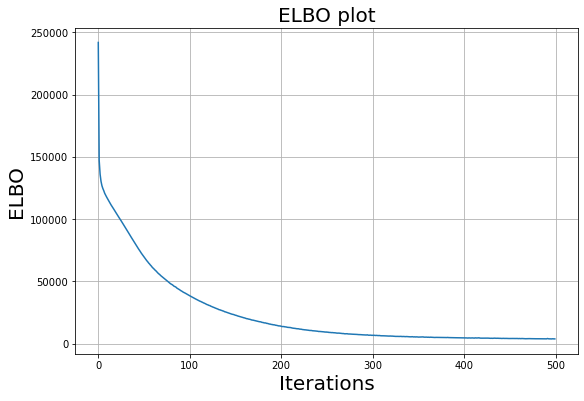

In [8]:
plt.figure(figsize=(9,6))
plt.plot(elbos)
plt.grid()
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("ELBO", fontsize=20)
plt.title("ELBO plot", fontsize=20)
plt.show()

### Predict and evaluate

In [9]:
# Predict
posterior_samples = 1000        # how many posterior "networks" to use for prediction
train_evaluation = evaluate.evaluate_class(bnn, train_loader, posterior_samples=posterior_samples, 
                               device=device, dataset="MNIST, Train data", num_classes=10, rounded=4)
test_evaluation = evaluate.evaluate_class(bnn, test_loader, posterior_samples=posterior_samples, 
                               device=device, dataset="MNIST, Test data", num_classes=10, rounded=4)

print("Train evaluation:")
for key, value in train_evaluation.items():
    print(key + str(":"), value)
print("\nTest evaluation:")
for key, value in test_evaluation.items():
    print(key + str(":"), value)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Train evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: MNIST, Train data
Number of posterior samples: 1000
Average NLPD: 0.0445
Average accuracy: 0.9938
Average AUROC: 1.0
Average ECE: 0.0284

Test evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: MNIST, Test data
Number of posterior samples: 1000
Average NLPD: 0.0682
Average accuracy: 0.9814
Average AUROC: 0.9998
Average ECE: 0.02


C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


# One cell pipeline

In [ ]:
%%time
# one cell pipeline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# Network hyperparameters        
n_epochs = 500
batch_size_train = 128
batch_size_test = 128
learning_rate = 1e-3


# Dataset size
train_size = 10000
test_size = 10000


# Data
train_subset = data.create_subset(train_data, train_size)
test_subset = data.create_subset(test_data, test_size)

train_loader = data.create_loader(train_data, device=device)
test_loader = data.create_loader(test_data, device=device)


# Model 
net = model.CNN_MNIST().to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
obs_model = tyxe.likelihoods.Categorical(train_size)
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)
bnn.name = guide_name + " Variational BNN" + likelihood_name + prior_name


# Fit
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": learning_rate})
elbos = []    
bnn.fit(train_loader, optim, n_epochs, callback, device=device)


# Predict
posterior_samples = 500        # how many posterior "networks" to use for prediction
train_evaluation = evaluate.evaluate_class(bnn, train_loader, posterior_samples=posterior_samples, 
                               device=device, dataset="MNIST, Train data", num_classes=10, rounded=4)
test_evaluation = evaluate.evaluate_class(bnn, test_loader, posterior_samples=posterior_samples, 
                               device=device, dataset="MNIST, Test data", num_classes=10, rounded=4)


# Plot
plt.figure(figsize=(9,6))
plt.plot(elbos)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("ELBO", fontsize=20)
plt.title("ELBO plot", fontsize=20)
plt.show()

print("Train evaluation:")
for key, value in train_evaluation.items():
    print(key + str(":"), value)
print("\nTest evaluation:")
for key, value in test_evaluation.items():
    print(key + str(":"), value)

## 2) Hamiltonian Monte Carlo (HMC)

In [10]:
%%time
# one cell pipeline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# Network hyperparameters        
batch_size_train = 128
batch_size_test = 128


# Dataset size
train_size = 4000
test_size = 4000


# Data
train_subset = data_loaders.create_subset(train_data, train_size)
test_subset = data_loaders.create_subset(test_data, test_size)

train_loader = data_loaders.create_loader(train_data, device=device)
test_loader = data_loaders.create_loader(test_data, device=device)


# Model 
net = model.CNN_MNIST().to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
likelihood = tyxe.likelihoods.Categorical(train_size)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=20, target_accept_prob=0.7)
kernel_name = "HMC"
bnn = tyxe.bnn.MCMC_BNN(net, prior, likelihood, kernel)
bnn.name = kernel_name + ", MCMC BNN" + likelihood_name + prior_name


# Fit
pyro.clear_param_store()
bnn.fit(train_loader, 100000, warmup_steps=30000)

Sample:  46%|███████████████▌                  | 59718/130000 [2:48:17,  5.58it/s, step size=2.88e-02, acc. prob=0.259]

KeyboardInterrupt: 

In [12]:
# Predict
posterior_samples = 10        # how many posterior "networks" to use for prediction
evaluation = evaluate.evaluate_class(bnn, test_loader, posterior_samples=posterior_samples, 
                               device=device, dataset="MNIST", num_classes=10, rounded=4)

for key,  value in evaluation.items():
    print(key + str(":"), value)

ValueError: No samples found from MCMC run.